# Comment Sentiment Analysis

In this notebook, we'll test the hypothesis that you can predict either Effies or Cannes Lions from the sentiment of Campaign Brief comments. 

To do that, we've scraped data from Campaign Brief for award-winning and non-award winning work over the last 10 years. 

In [231]:
import pandas as pd
import numpy as np
import vaderSentiment
import os
from pathlib import Path
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import csv
import glob
import os
import statsmodels.api as sm

In [232]:
from matplotlib import pyplot as plt

## Data Cleaning

First, we'll clean and organise the data.

In [233]:
path = Path('C:\\Users\\yaspa\\OneDrive\\Documents\\Python\\Campaign-Brief-Analysis\\Data\\Non-Effies')
csv_files = glob.glob(os.path.join(path, '*.csv'))

In [234]:
glued_dataframe = pd.DataFrame()

for f in csv_files:
    
    #read csv file
    df = pd.read_csv(f)
    
    #adding key metrics
    df['campaign_name'] = Path(f).stem
    df['awarded'] = 'Non Award Winners'
    
    #drop first row
    df = df.drop([0])
    df['num_comments'] = len(df.index)
    
    glued_dataframe = glued_dataframe.append(df).reset_index(drop=True)
    
    

C:\Users\yaspa\AppData\Local\Temp\ipykernel_11212\3763169515.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  glued_dataframe = glued_dataframe.append(df).reset_index(drop=True)
C:\Users\yaspa\AppData\Local\Temp\ipykernel_11212\3763169515.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  glued_dataframe = glued_dataframe.append(df).reset_index(drop=True)
C:\Users\yaspa\AppData\Local\Temp\ipykernel_11212\3763169515.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  glued_dataframe = glued_dataframe.append(df).reset_index(drop=True)
C:\Users\yaspa\AppData\Local\Temp\ipykernel_11212\3763169515.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

In [235]:
glued_dataframe.tail()

,Field1,Field2,campaign_name,awarded,num_comments,Time,Field2_text,Field2_links,Field3,fn,Field,Comment,Title,Image
763,What?!,"Snap, maybe the Transport Accident Commission ...",zero-deaths,Non Award Winners,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
764,Really,The framing of the sound boom in the beginning...,zero-deaths,Non Award Winners,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
765,D#,it’s beautifully dramatic and heart felt… but ...,zero-deaths,Non Award Winners,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
766,vince the cleaner,I’m with doubting tom on this one. Unscripted ...,zero-deaths,Non Award Winners,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
767,Joe,Unscripted or not…. Such a great idea. Well do...,zero-deaths,Non Award Winners,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [236]:
# getting our Effies database

path = Path('C:\\Users\\yaspa\\OneDrive\\Documents\\Python\\Campaign-Brief-Analysis\\Data\\Effies')
csv_files = glob.glob(os.path.join(path, '*.csv'))

In [237]:
effies_glued_dataframe = pd.DataFrame()

for f in csv_files:
    
    #read csv file
    df = pd.read_csv(f)
    
    #getting file name from path object
    df['campaign_name'] = Path(f).stem
    df['awarded'] = 'Effie Winners'
    
    #drop first row + counting comments
    df = df.drop([0])
    df['num_comments'] = len(df.index)
    
    effies_glued_dataframe = effies_glued_dataframe.append(df).reset_index(drop=True)

C:\Users\yaspa\AppData\Local\Temp\ipykernel_11212\185289760.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  effies_glued_dataframe = effies_glued_dataframe.append(df).reset_index(drop=True)
C:\Users\yaspa\AppData\Local\Temp\ipykernel_11212\185289760.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  effies_glued_dataframe = effies_glued_dataframe.append(df).reset_index(drop=True)
C:\Users\yaspa\AppData\Local\Temp\ipykernel_11212\185289760.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  effies_glued_dataframe = effies_glued_dataframe.append(df).reset_index(drop=True)
C:\Users\yaspa\AppData\Local\Temp\ipykernel_11212\185289760.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pan

In [238]:
effies_glued_dataframe.tail(20)

,Field1,Field2,campaign_name,awarded,num_comments,Title,Field,Comment
217,Anonymous,"brilliant, envious. great idea.",tontine,Effie Winners,30,NaN,NaN,NaN
218,Anonymous,Bloody brilliant! Both the work and the commen...,tontine,Effie Winners,30,NaN,NaN,NaN
219,A²,"Such a simple concept, yet completely brillian...",tontine,Effie Winners,30,NaN,NaN,NaN
220,Anonymous,so let me get this right. the client wants to ...,tontine,Effie Winners,30,NaN,NaN,NaN
221,Anonymous,I just want one of Jen’s pillows.,tontine,Effie Winners,30,NaN,NaN,NaN
222,Anonymous,“Honey our Tontine pillow is out of date.”\n“O...,tontine,Effie Winners,30,NaN,NaN,NaN
223,Anonymous,"What happens if, by the time you buy it, it’s ...",tontine,Effie Winners,30,NaN,NaN,NaN
224,Anonymous,"But 5:04, the closer you are to the use by dat...",tontine,Effie Winners,30,NaN,NaN,NaN
225,Anonymous,Wash your fucking pillows pussies.,tontine,Effie Winners,30,NaN,NaN,NaN
226,Mr Official,Official score: 3.75/5* (this feels to me like...,tontine,Effie Winners,30,NaN,NaN,NaN


In [239]:
comments_dataframe = pd.concat([glued_dataframe, effies_glued_dataframe])\
    .reset_index(drop=True)

In [240]:
comments_dataframe

,Field1,Field2,campaign_name,awarded,num_comments,Time,Field2_text,Field2_links,Field3,fn,Field,Comment,Title,Image
0,Funny,I had a giggle. Nice.,aami-insurance,Non Award Winners,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Frequent snag burner,Love it,aami-insurance,Non Award Winners,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TV,Ouch,aami-insurance,Non Award Winners,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Ryfan,Nice one mate,aami-insurance,Non Award Winners,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Pun Meister,Were the fire effects added in Flame?,aami-insurance,Non Award Winners,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,Anonymous,Jen wins best copywriter on this thread.\nps: ...,tontine,Effie Winners,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,Anonymous,I don’t give a fuck about the microscopic thin...,tontine,Effie Winners,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,Anonymous,"Agreed, it is a clever business solution by th...",tontine,Effie Winners,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003,Anonymous,over produced award video.,tontine,Effie Winners,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [241]:
comments_dataframe = comments_dataframe[['Field1', 'Field2', 'campaign_name', 'awarded', 'num_comments']]

In [242]:
comments_dataframe

,Field1,Field2,campaign_name,awarded,num_comments
0,Funny,I had a giggle. Nice.,aami-insurance,Non Award Winners,15
1,Frequent snag burner,Love it,aami-insurance,Non Award Winners,15
2,TV,Ouch,aami-insurance,Non Award Winners,15
3,Ryfan,Nice one mate,aami-insurance,Non Award Winners,15
4,Pun Meister,Were the fire effects added in Flame?,aami-insurance,Non Award Winners,15
...,...,...,...,...,...
1000,Anonymous,Jen wins best copywriter on this thread.\nps: ...,tontine,Effie Winners,30
1001,Anonymous,I don’t give a fuck about the microscopic thin...,tontine,Effie Winners,30
1002,Anonymous,"Agreed, it is a clever business solution by th...",tontine,Effie Winners,30
1003,Anonymous,over produced award video.,tontine,Effie Winners,30


In [243]:
rename_dict = {'Field1': 'name', 'Field2': 'comment'}

comments_dataframe = comments_dataframe.rename(columns=rename_dict)
comments_df = comments_dataframe.copy()

comments_df

,name,comment,campaign_name,awarded,num_comments
0,Funny,I had a giggle. Nice.,aami-insurance,Non Award Winners,15
1,Frequent snag burner,Love it,aami-insurance,Non Award Winners,15
2,TV,Ouch,aami-insurance,Non Award Winners,15
3,Ryfan,Nice one mate,aami-insurance,Non Award Winners,15
4,Pun Meister,Were the fire effects added in Flame?,aami-insurance,Non Award Winners,15
...,...,...,...,...,...
1000,Anonymous,Jen wins best copywriter on this thread.\nps: ...,tontine,Effie Winners,30
1001,Anonymous,I don’t give a fuck about the microscopic thin...,tontine,Effie Winners,30
1002,Anonymous,"Agreed, it is a clever business solution by th...",tontine,Effie Winners,30
1003,Anonymous,over produced award video.,tontine,Effie Winners,30


## Sentiment Analysis and Aggregation

Now, we'll use VADER to classify the sentiment of each comment

In [244]:
# import SentimentIntensityAnalyzer class
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#function to print sentiments of string
def sentiment_scores(sentence):
    
    #create SentimentIntensityAnalyzer object
    sid_obj = SentimentIntensityAnalyzer()
    
    #polarity_scores method of SentimentIntensityAnalyzer
    #object gives a sentiment dictionary which contains pos, neg, neu, 
    # and compound scores
    
    try:
        sentiment_dict = sid_obj.polarity_scores(sentence)
    except TypeError:
        sentiment_dict = {'neg':'0', 'neu': '0', 'pos': '0', 'compound': '0'}
    
    #return four scores
    return list((sentiment_dict['neg'], sentiment_dict['neu'],\
            sentiment_dict['pos'], sentiment_dict['compound']))

In [245]:
#creating a df of scores and naming columns
sentiment_df = comments_df\
    .apply(lambda x: sentiment_scores(x['comment']), axis=1, result_type = 'expand')

In [246]:
#renaming columns
sentiment_df.columns = ['pos', 'neg', 'neu', 'compound']

In [247]:
sentiment_df

,pos,neg,neu,compound
0,0.0,0.349,0.651,0.6808
1,0.0,0.192,0.808,0.6369
2,0.0,1.0,0.0,0.0
3,0.0,0.417,0.583,0.4215
4,0.286,0.714,0.0,-0.34
...,...,...,...,...
1000,0.0,0.612,0.388,0.9473
1001,0.161,0.809,0.029,-0.9055
1002,0.0,0.712,0.288,0.8442
1003,0.0,0.462,0.538,0.5423


In [248]:
#merging our dataframes on indexes

final_comment_df = comments_df.merge(sentiment_df, left_index=True, right_index=True)
final_comment_df

,name,comment,campaign_name,awarded,num_comments,pos,neg,neu,compound
0,Funny,I had a giggle. Nice.,aami-insurance,Non Award Winners,15,0.0,0.349,0.651,0.6808
1,Frequent snag burner,Love it,aami-insurance,Non Award Winners,15,0.0,0.192,0.808,0.6369
2,TV,Ouch,aami-insurance,Non Award Winners,15,0.0,1.0,0.0,0.0
3,Ryfan,Nice one mate,aami-insurance,Non Award Winners,15,0.0,0.417,0.583,0.4215
4,Pun Meister,Were the fire effects added in Flame?,aami-insurance,Non Award Winners,15,0.286,0.714,0.0,-0.34
...,...,...,...,...,...,...,...,...,...
1000,Anonymous,Jen wins best copywriter on this thread.\nps: ...,tontine,Effie Winners,30,0.0,0.612,0.388,0.9473
1001,Anonymous,I don’t give a fuck about the microscopic thin...,tontine,Effie Winners,30,0.161,0.809,0.029,-0.9055
1002,Anonymous,"Agreed, it is a clever business solution by th...",tontine,Effie Winners,30,0.0,0.712,0.288,0.8442
1003,Anonymous,over produced award video.,tontine,Effie Winners,30,0.0,0.462,0.538,0.5423


## Grouping Training Data Into Training and Test

We'll then aggregate the data up into single rows. Potential features will be:

- Average sentiment
- Median sentiment (rounded up)
- Min sentiment
- Max sentiment
- Positive ratio
- Neutral ratio
- Negative ratio
- Number of comments


In [249]:
# aggregating dataframe

#creating aggregation dictionary
agg_dict = {'awarded': 'max', # retaining or independent variable
            'num_comments': 'max', #number comments
           'pos': ['mean', 'min', 'max'], # average, minimum, maximum positive sentiment
           'neu': 'mean', #average neutral sentiment
           'neg': ['mean', 'min', 'max'], # average, minimum, maximum positive sentiment
           'compound': 'mean'} #average overall sentiment

agg_df = final_comment_df.groupby('campaign_name').agg(agg_dict)

In [250]:
#flatten index
agg_df.columns = agg_df.columns.to_flat_index()
agg_df

,"(awarded, max)","(num_comments, max)","(pos, mean)","(pos, min)","(pos, max)","(neu, mean)","(neg, mean)","(neg, min)","(neg, max)","(compound, mean)"
campaign_name,,,,,,,,,,
NRMA-Car-Difference,Effie Winners,20,0.000000,0,0,0.000000,0.000000,0,0,0.000000
Rabobank-stealing-dreams,Effie Winners,27,0.079259,0.0,0.767,0.243630,0.677074,0.0,1.0,0.324274
aami-insurance,Non Award Winners,15,0.038800,0.0,0.286,0.298533,0.662667,0.192,1.0,0.381373
aff-don't-ignore-cough,Effie Winners,1,0.149000,0.149,0.149,0.000000,0.851000,0.851,0.851,-0.487100
afl-2021,Non Award Winners,5,0.090200,0.0,0.152,0.093600,0.816400,0.724,0.91,-0.133160
afl-mini-legends,Non Award Winners,3,0.000000,0.0,0.0,0.507333,0.492667,0.0,0.796,0.674933
afl-partnership,Non Award Winners,34,0.053941,0.0,0.416,0.252971,0.693029,0.22,1.0,0.430332
afl-quietly,Non Award Winners,55,0.155455,0.0,1.0,0.127036,0.717491,0.0,1.0,-0.006409
aldi-more-merrier,Non Award Winners,60,0.058200,0.0,0.424,0.261383,0.680450,0.0,1.0,0.389072


In [251]:
agg_df.columns = ['awarded', 'num_comments', 'avg_pos', 'min_pos', \
                 'max_pos', 'avg_neu', 'avg_neg', 'min_neg', 'max_neg', \
                 'avg_sent']
agg_df = agg_df.reset_index()


In [252]:
agg_df = agg_df.astype({'min_pos':'float',
                        'max_pos':'float',
                       'min_neg': 'float',
                       'max_neg': 'float'})

In [253]:
agg_df.dtypes

campaign_name     object
awarded           object
num_comments       int64
avg_pos          float64
min_pos          float64
max_pos          float64
avg_neu          float64
avg_neg          float64
min_neg          float64
max_neg          float64
avg_sent         float64
dtype: object

## EDA

We'll have a look at boxplots for our datapoints.

In [254]:
#renaming columns

column_names = {'num_comments': 'Number of Comments', 
               'awarded': 'Award Status',
               'avg_sent': 'Average Sentiment',
               'avg_neg': 'Average Negativity',
               'avg_pos': 'Average Positivity'}

agg_df = agg_df.rename(columns=column_names)

In [255]:
#setting boxplot colours

palette = ['orange', 'grey']

<AxesSubplot:xlabel='min_pos', ylabel='Award Status'>

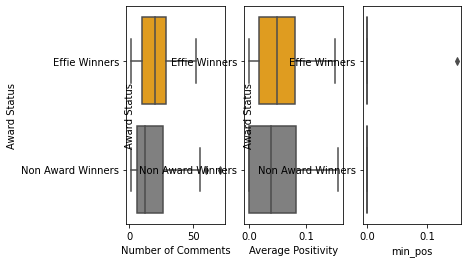

In [256]:
fig, axs = plt.subplots(ncols=3)
sns.boxplot(x='Number of Comments', y='Award Status', data=agg_df, ax=axs[0], palette=palette)
sns.boxplot(x='Average Positivity', y='Award Status', data=agg_df, ax=axs[1], palette=palette)
sns.boxplot(x='min_pos',y='Award Status', data=agg_df, ax=axs[2], palette=palette)

<AxesSubplot:xlabel='Average Negativity', ylabel='Award Status'>

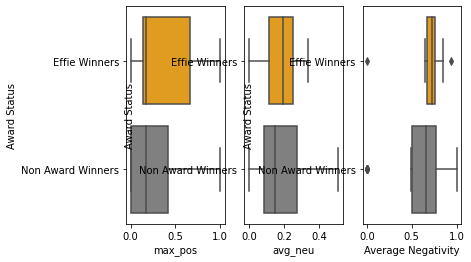

In [257]:
fig, axs = plt.subplots(ncols=3)
sns.boxplot(x='max_pos', y='Award Status', data=agg_df, ax=axs[0], palette=palette)
sns.boxplot(x='avg_neu', y='Award Status', data=agg_df, ax=axs[1], palette=palette)
sns.boxplot(x='Average Negativity',y='Award Status', data=agg_df, ax=axs[2], palette=palette)

<AxesSubplot:xlabel='Average Sentiment', ylabel='Award Status'>

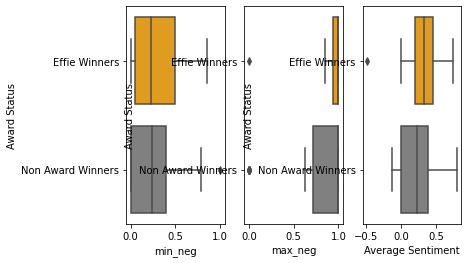

In [258]:
fig, axs = plt.subplots(ncols=3)
sns.boxplot(x='min_neg', y='Award Status', data=agg_df, ax=axs[0], palette=palette)
sns.boxplot(x='max_neg', y='Award Status', data=agg_df, ax=axs[1], palette=palette)
sns.boxplot(x='Average Sentiment',y='Award Status', data=agg_df, ax=axs[2], palette=palette)

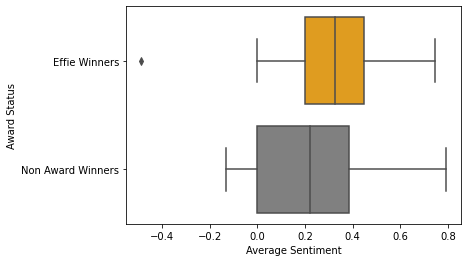

In [259]:
# average sentiment
sns.boxplot(x='Average Sentiment', y='Award Status', data=agg_df,
            palette=palette).get_figure().savefig('./Graphs/effies_avg-sent.png', bbox_inches='tight')


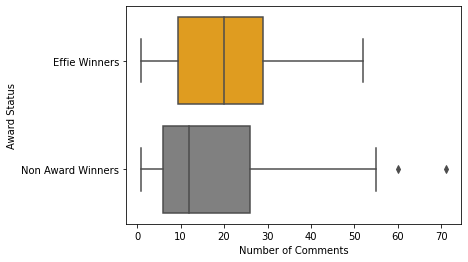

In [260]:
# num comments

sns.boxplot(x='Number of Comments', y='Award Status', data=agg_df,
            palette=palette).get_figure().savefig('./Graphs/effies_num-comments.png', bbox_inches='tight')


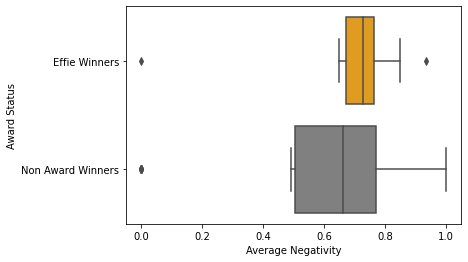

In [261]:
# average negativity

sns.boxplot(x='Average Negativity', y='Award Status', data=agg_df, 
            palette=palette).get_figure().savefig('./Graphs/effies_avg-neg.png', bbox_inches='tight')



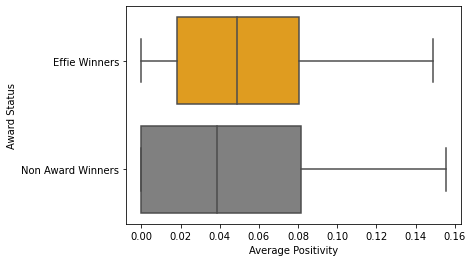

In [262]:
#avg pos

sns.boxplot(x='Average Positivity', y='Award Status', data=agg_df, palette=palette).get_figure().savefig('./Graphs/effies_avg-pos.png', bbox_inches='tight')



The most useful features are:

- Average sentiment
- Max pos
- Avg neu
- Avg neg
- Num comments
- Avg pos

In [ ]:
#defining dependent and independent variables
Xtrain = agg_df[['num_comments', 'avg_pos', 'min_pos', \
                 'max_pos', 'avg_neu', 'avg_neg', 'min_neg', 'max_neg', \
                 'avg_sent']]
Ytrain = agg_df[["awarded"]]

Xtrain = Xtrain.astype(float)
Ytrain = Ytrain.astype(float)

In [32]:
#defining dependent and independent variables
Xtrain = agg_df[['num_comments', 'avg_sent', 'avg_pos', 'avg_neg']]
Ytrain = agg_df[["awarded"]]

Xtrain = Xtrain.astype(float)
Ytrain = Ytrain.astype(float)

In [33]:
log_reg = sm.Logit(Ytrain, Xtrain).fit()

Optimization terminated successfully.
         Current function value: 0.566182
         Iterations 5


In [34]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:                awarded   No. Observations:                   56
Model:                          Logit   Df Residuals:                       52
Method:                           MLE   Df Model:                            3
Date:                Mon, 31 Oct 2022   Pseudo R-squ.:                 -0.1429
Time:                        21:12:17   Log-Likelihood:                -31.706
converged:                       True   LL-Null:                       -27.743
Covariance Type:            nonrobust   LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
num_comments    -0.0141      0.020     -0.694      0.487      -0.054       0.026
avg_sent        -0.5259      1.508     -0.349      0.727      -3.482       2.430
avg_pos          0.1296      9.694      0.01

### Linear Discriminant Analysis

Let's give Linear Discriminant Analysis a go.

In [39]:
# splitting data into train/test and stratifying it
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xtrain, Ytrain,
                                                stratify=Ytrain,
                                                    test_size=0.25)


In [40]:
len(Xtrain)

42

In [41]:
len(Ytrain)

42

In [42]:
# evaluate a lda model on the dataset
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=10, n_redundant=0, random_state=1)
# define model
LDA_model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(LDA_model, Xtrain, Ytrain.values.ravel(), scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.794 (0.068)


In [44]:
# evaluate a qda model on the dataset
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=10, n_redundant=0, random_state=1)
# define model
QDA_model = QuadraticDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(QDA_model, Xtrain, Ytrain.values.ravel(), scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.700 (0.116)


In [47]:
# evaluate a logistic regression model on the dataset
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=10, n_redundant=0, random_state=1)
# define model
LR_model = LogisticRegression()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(LR_model, Xtrain, Ytrain.values.ravel(), scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.803 (0.069)


In [50]:
# using a confusion matrix with LDA

from sklearn.metrics import confusion_matrix

LDA_model.fit(Xtrain, Ytrain.values.ravel())

Ypred = LDA_model.predict(Xtest)

confusion_matrix(Ytest, Ypred)

So LDA was just classifying everything as not awarded. 

In [53]:
QDA_model.fit(Xtrain, Ytrain.values.ravel())

Ypred = QDA_model.predict(Xtest)

confusion_matrix(Ytest, Ypred)

array([[10,  1],
       [ 3,  0]], dtype=int64)

In [54]:
LR_model.fit(Xtrain, Ytrain.values.ravel())

Ypred = LR_model.predict(Xtest)

confusion_matrix(Ytest, Ypred)

array([[11,  0],
       [ 3,  0]], dtype=int64)

## Conclusions

Logistic regression can't converge. What about Cannes awards?

# Testing Cannes Data

Given Effies data failed, we'll test Cannes data. 

In [207]:
#getting Cannes databases

path = Path('C:\\Users\\yaspa\\OneDrive\\Documents\\Python\\Campaign-Brief-Analysis\\Data\\Cannes-Lions')
csv_files = glob.glob(os.path.join(path, '*.csv'))

In [208]:
cannes_glued_dataframe = pd.DataFrame()

for f in csv_files:
    
    #read csv file
    df = pd.read_csv(f)
    
    #getting file name from path object
    df['campaign_name'] = Path(f).stem
    df['awarded'] = 'Cannes Winner'
    
    #drop first row + counting comments
    df = df.drop([0])
    df['num_comments'] = len(df.index)
    
    cannes_glued_dataframe = cannes_glued_dataframe.append(df).reset_index(drop=True)

C:\Users\yaspa\AppData\Local\Temp\ipykernel_11212\67271735.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cannes_glued_dataframe = cannes_glued_dataframe.append(df).reset_index(drop=True)
C:\Users\yaspa\AppData\Local\Temp\ipykernel_11212\67271735.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cannes_glued_dataframe = cannes_glued_dataframe.append(df).reset_index(drop=True)
C:\Users\yaspa\AppData\Local\Temp\ipykernel_11212\67271735.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cannes_glued_dataframe = cannes_glued_dataframe.append(df).reset_index(drop=True)
C:\Users\yaspa\AppData\Local\Temp\ipykernel_11212\67271735.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

In [209]:
comments_dataframe = pd.concat([glued_dataframe, cannes_glued_dataframe])\
    .reset_index(drop=True)

In [210]:
comments_dataframe = comments_dataframe[['Field1', 'Field2', 'campaign_name', 'awarded', 'num_comments']]

In [211]:
rename_dict = {'Field1': 'name', 'Field2': 'comment'}

comments_dataframe = comments_dataframe.rename(columns=rename_dict)
comments_df = comments_dataframe.copy()

comments_df

,name,comment,campaign_name,awarded,num_comments
0,Funny,I had a giggle. Nice.,aami-insurance,Non Award Winners,15
1,Frequent snag burner,Love it,aami-insurance,Non Award Winners,15
2,TV,Ouch,aami-insurance,Non Award Winners,15
3,Ryfan,Nice one mate,aami-insurance,Non Award Winners,15
4,Pun Meister,Were the fire effects added in Flame?,aami-insurance,Non Award Winners,15
...,...,...,...,...,...
1097,RC,Lovely stuff guys,volkswagen-ad-break,Cannes Winner,18
1098,two things,"Game idea is cool, but is probably boring to p...",volkswagen-ad-break,Cannes Winner,18
1099,Sooooo,You took Volvo Interception and made it into a...,volkswagen-ad-break,Cannes Winner,18
1100,Credit where due,I wish I thought of this. Strap in for the ava...,volkswagen-ad-break,Cannes Winner,18


In [212]:
#creating a df of scores and naming columns
sentiment_df = comments_df\
    .apply(lambda x: sentiment_scores(x['comment']), axis=1, result_type = 'expand')

In [213]:
#renaming columns
sentiment_df.columns = ['pos', 'neg', 'neu', 'compound']

In [214]:
#merging our dataframes on indexes

final_comment_df = comments_df.merge(sentiment_df, left_index=True, right_index=True)
final_comment_df

,name,comment,campaign_name,awarded,num_comments,pos,neg,neu,compound
0,Funny,I had a giggle. Nice.,aami-insurance,Non Award Winners,15,0.0,0.349,0.651,0.6808
1,Frequent snag burner,Love it,aami-insurance,Non Award Winners,15,0.0,0.192,0.808,0.6369
2,TV,Ouch,aami-insurance,Non Award Winners,15,0.0,1.0,0.0,0.0
3,Ryfan,Nice one mate,aami-insurance,Non Award Winners,15,0.0,0.417,0.583,0.4215
4,Pun Meister,Were the fire effects added in Flame?,aami-insurance,Non Award Winners,15,0.286,0.714,0.0,-0.34
...,...,...,...,...,...,...,...,...,...
1097,RC,Lovely stuff guys,volkswagen-ad-break,Cannes Winner,18,0.0,0.345,0.655,0.5859
1098,two things,"Game idea is cool, but is probably boring to p...",volkswagen-ad-break,Cannes Winner,18,0.085,0.754,0.161,0.7992
1099,Sooooo,You took Volvo Interception and made it into a...,volkswagen-ad-break,Cannes Winner,18,0.0,1.0,0.0,0.0
1100,Credit where due,I wish I thought of this. Strap in for the ava...,volkswagen-ad-break,Cannes Winner,18,0.0,0.847,0.153,0.4019


In [215]:
# aggregating dataframe

#creating aggregation dictionary
agg_dict = {'awarded': 'max', # retaining or independent variable
            'num_comments': 'max', #number comments
           'pos': ['mean', 'min', 'max'], # average, minimum, maximum positive sentiment
           'neu': 'mean', #average neutral sentiment
           'neg': ['mean', 'min', 'max'], # average, minimum, maximum positive sentiment
           'compound': 'mean'} #average overall sentiment

agg_df = final_comment_df.groupby('campaign_name').agg(agg_dict)

In [216]:
#flatten index
agg_df.columns = agg_df.columns.to_flat_index()

In [217]:
agg_df.columns = ['awarded', 'num_comments', 'avg_pos', 'min_pos', \
                 'max_pos', 'avg_neu', 'avg_neg', 'min_neg', 'max_neg', \
                 'avg_sent']
agg_df = agg_df.reset_index()

In [218]:
# converting data to floats

agg_df = agg_df.astype({'min_pos':'float',
                        'max_pos':'float',
                       'min_neg': 'float',
                       'max_neg': 'float'})

## EDA

Now, we'll explore this data using box plots.

In [219]:
#renaming columns

column_names = {'num_comments': 'Number of Comments', 
               'awarded': 'Award Status',
               'avg_sent': 'Average Sentiment',
               'avg_neg': 'Average Negativity',
               'avg_pos': 'Average Positivity'}

agg_df = agg_df.rename(columns=column_names)

<AxesSubplot:xlabel='min_pos', ylabel='Award Status'>

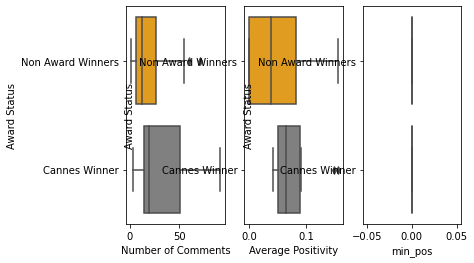

In [220]:
fig, axs = plt.subplots(ncols=3)
sns.boxplot(x='Number of Comments', y='Award Status', data=agg_df, ax=axs[0], palette=palette)
sns.boxplot(x='Average Positivity', y='Award Status', data=agg_df, ax=axs[1], palette=palette)
sns.boxplot(x='min_pos',y='Award Status', data=agg_df, ax=axs[2], palette=palette)

<AxesSubplot:xlabel='Average Negativity', ylabel='Award Status'>

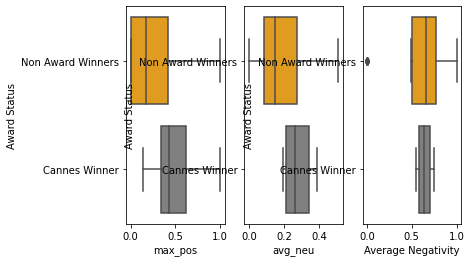

In [221]:
fig, axs = plt.subplots(ncols=3)
sns.boxplot(x='max_pos', y='Award Status', data=agg_df, ax=axs[0], palette=palette)
sns.boxplot(x='avg_neu', y='Award Status', data=agg_df, ax=axs[1], palette=palette)
sns.boxplot(x='Average Negativity',y='Award Status', data=agg_df, ax=axs[2], palette=palette)

<AxesSubplot:xlabel='Average Sentiment', ylabel='Award Status'>

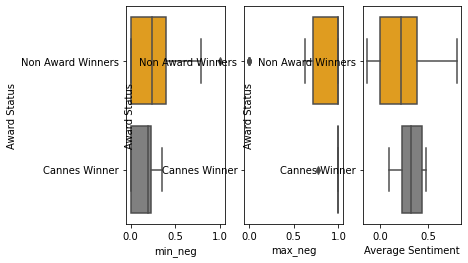

In [222]:
fig, axs = plt.subplots(ncols=3)
sns.boxplot(x='min_neg', y='Award Status', data=agg_df, ax=axs[0], palette=palette)
sns.boxplot(x='max_neg', y='Award Status', data=agg_df, ax=axs[1], palette=palette)
sns.boxplot(x='Average Sentiment', y='Award Status', data=agg_df, ax=axs[2], palette=palette)

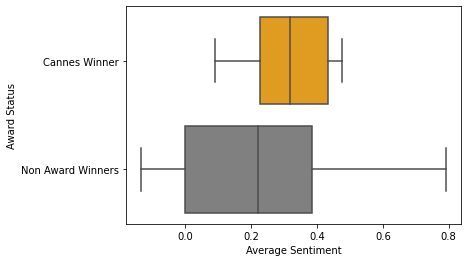

In [227]:
# average sentiment
sns.boxplot(x='Average Sentiment', y='Award Status', data=agg_df, 
            order = ['Cannes Winner', 'Non Award Winners'], palette=palette).get_figure().savefig('./Graphs/cannes_avg-sent.png', bbox_inches='tight')


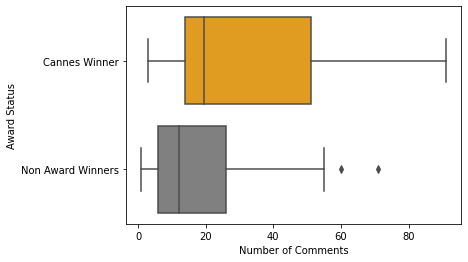

In [228]:
# num comments

sns.boxplot(x='Number of Comments', y='Award Status', data=agg_df, 
            order = ['Cannes Winner', 'Non Award Winners'], palette=palette).get_figure().savefig('./Graphs/cannes_num-comments.png', bbox_inches='tight')


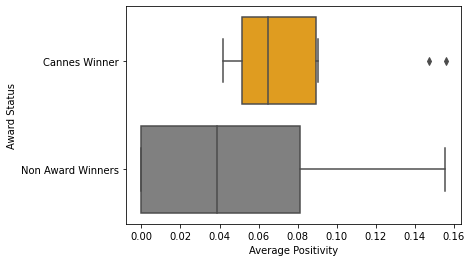

In [229]:
# average positive

sns.boxplot(x='Average Positivity', y='Award Status', data=agg_df, 
            order = ['Cannes Winner', 'Non Award Winners'], palette=palette).get_figure().savefig('./Graphs/cannes_avg-pos.png', bbox_inches='tight')


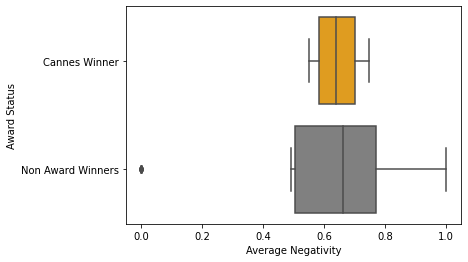

In [230]:
# average negative

sns.boxplot(x='Average Negativity', y='Award Status', data=agg_df, 
            order = ['Cannes Winner', 'Non Award Winners'], palette=palette).get_figure().savefig('./Graphs/cannes_avg-neg.png', bbox_inches='tight')


Cannes-winning work tended to have a slightly higher average sentiment (although there were larger variations in non-award-winning work). Cannes-winning work had slightly more comments.

Overall, comments skewed far more negative than positive (50-60% all comment elements were negative, vs under 10% of positive comment elements). 

In [74]:
#defining dependent and independent variables
Xtrain = agg_df[['num_comments', 'avg_pos', 'min_pos', \
                 'max_pos', 'avg_neu', 'avg_neg', 'min_neg', 'max_neg', \
                 'avg_sent']]
Ytrain = agg_df[["awarded"]]

Xtrain = Xtrain.astype(float)
Ytrain = Ytrain.astype(float)

In [75]:
#defining dependent and independent variables
Xtrain = agg_df[['num_comments', 'avg_sent']]
Ytrain = agg_df[["awarded"]]

Xtrain = Xtrain.astype(float)
Ytrain = Ytrain.astype(float)

In [76]:
log_reg = sm.Logit(Ytrain, Xtrain).fit(maxiter=200)

Optimization terminated successfully.
         Current function value: 0.602356
         Iterations 5


In [77]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:                awarded   No. Observations:                   55
Model:                          Logit   Df Residuals:                       53
Method:                           MLE   Df Model:                            1
Date:                Mon, 31 Oct 2022   Pseudo R-squ.:                 -0.2704
Time:                        21:20:08   Log-Likelihood:                -33.130
converged:                       True   LL-Null:                       -26.078
Covariance Type:            nonrobust   LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
num_comments    -0.0053      0.014     -0.394      0.693      -0.032       0.021
avg_sent        -2.7201      1.290     -2.108      0.035      -5.249      -0.191


## Model Training

We'll trial some simple explainable models, logistic regression and linear discriminant analysis, to see which performs better.


In [78]:
# splitting data into train/test and stratifying it
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xtrain, Ytrain,
                                                stratify=Ytrain,
                                                    test_size=0.25)


In [90]:
# evaluate a lda model on the dataset
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=10, n_redundant=0, random_state=1)
# define model
LDA_model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(LDA_model, Xtrain, Ytrain.values.ravel(), scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.545 (0.287)


In [88]:
# evaluate a qda model on the dataset
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=10, n_redundant=0, random_state=1)
# define model
QDA_model = QuadraticDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(QDA_model, Xtrain, Ytrain.values.ravel(), scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize result
print('Mean ROC AUC: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean ROC AUC: 0.702 (0.289)


In [89]:
# evaluate a logistic regression model on the dataset
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=10, n_redundant=0, random_state=1)
# define model
LR_model = LogisticRegression()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(LR_model, Xtrain, Ytrain.values.ravel(), scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.586 (0.299)


In [82]:
LDA_model.fit(Xtrain, Ytrain.values.ravel())

Ypred = LDA_model.predict(Xtest)

confusion_matrix(Ytest, Ypred)

array([[11,  0],
       [ 2,  1]], dtype=int64)

In [83]:
QDA_model.fit(Xtrain, Ytrain.values.ravel())

Ypred = QDA_model.predict(Xtest)

confusion_matrix(Ytest, Ypred)

array([[11,  0],
       [ 1,  2]], dtype=int64)

In [84]:
LR_model.fit(Xtrain, Ytrain.values.ravel())

Ypred = LR_model.predict(Xtest)

confusion_matrix(Ytest, Ypred)

array([[11,  0],
       [ 2,  1]], dtype=int64)

That's actually pretty good from the QDA model on the dataset. Let's see if we can use some oversampling to improve that. 

## Oversampling

We'll use a simple oversampling approach on our data.

In [91]:
! pip install imbalanced-learn

     -------------------------------------- 199.3/199.3 kB 1.3 MB/s eta 0:00:00


In [96]:
import imblearn
print(imblearn.__version__)
from imblearn.over_sampling import RandomOverSampler

0.9.1


In [97]:
oversample = RandomOverSampler(sampling_strategy='minority')

In [98]:
X_resampled, y_resampled = oversample.fit_resample(Xtrain, Ytrain)

In [102]:
print(len(y_resampled))

68


In [104]:
# training model on resampled data
# define model
QDA_model = QuadraticDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(QDA_model, X_resampled, y_resampled.values.ravel(), scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize result
print('Mean ROC AUC: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean ROC AUC: 0.759 (0.092)


In [105]:
QDA_model.fit(X_resampled, y_resampled.values.ravel())

Ypred = QDA_model.predict(Xtest)

confusion_matrix(Ytest, Ypred)

array([[5, 6],
       [1, 2]], dtype=int64)

## Model Inference

We'll finally see how well the models perform on the test data to see whether we can actually predict campaign success from comments.